# Elliptic PDE

In [1]:
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import gamma, kv
from qmcpy.integrand._integrand import Integrand
from qmcpy.accumulate_data.mlmc_data import MLMCData
from qmcpy.accumulate_data.mlqmc_data import MLQMCData
import qmcpy as qp

In [2]:
# matplotlib options
rc_fonts = {
    "text.usetex": True,
    "font.size": 14,
    "mathtext.default": "regular",
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "legend.fontsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.titlesize": 16,
    "font.family": "serif",
    "font.serif": "computer modern roman",
}
mpl.rcParams.update(rc_fonts)

In [3]:
# set random seed for reproducability
np.random.seed(9999)

We will apply various multilevel Monte Carlo and multilevel quasi-Monte Carlo methods to approximate the expected value of a quantity of interest derived from the solution of a one-dimensional partial differential equation (PDE), where the diffusion coefficient of the PDE is a lognormal Gaussian random field. This example problem serves as an important benchmark problem for various methods in the uncertainty quantification and quasi-Monte Carlo literature. It is often referred to as *the fruitfly problem* of uncertainty quantification.

## 1. Problem definition

Let $Q$ be a quantity of interest derived from the solution $u(x, \omega)$ of the one-dimensional partial differential equation (PDE)

$$-\frac{d}{dx}\bigg(a(x, \omega) \frac{d}{dx} u(x, \omega) \bigg) = f(x), \quad 0 \leq x \leq 1,$$
$$u(0, \cdot) = u_0,$$
$$u(1, \cdot) = u_1.$$

The notation $u(x, \omega)$ is used to indicate that the solution depends on both the spatial variable $x$ and the uncertain parameter $\omega$. This uncertainty is present because the diffusion coefficient, $a(x, \omega)$, is given by a lognormal Gaussian random field with given covariance function. A common choice for the covariance function is the so-called Mat&eacute;rn covariance function

$$c(x, y) = \hat{c}\bigg(\frac{\|x - y\|}{\lambda}\bigg)\quad \quad \hat{c}(r) = \frac{2^{1-\nu}}{\Gamma(\nu)} r^\nu K_\nu(r)$$

with $\Gamma$ the gamma function and $K_\nu$ the Bessel function of the second kind. This covariance function has two parameters: $\lambda$, the length scale, and $\nu$, the smoothness parameter.

We begin by defining the Mat&eacute;rn covariance function `Matern(x, y)`:

In [4]:
def Matern(x, y, smoothness=1, lengthscale=1):
    distance = abs(x - y)
    r = distance/lengthscale
    prefactor = 2**(1-smoothness)/gamma(smoothness)
    term1 = r**smoothness
    term2 = kv(smoothness, r)
    np.fill_diagonal(term2, 1)
    cov = prefactor * term1 * term2
    np.fill_diagonal(cov, 1)
    return cov

Let's take a look at the covariance matrix obtained by evaluating the covariance function in `n=25` equidistant points in `[0, 1]`. 

In [5]:
def get_covariance_matrix(pts, smoothness=1, lengthscale=1):
    X, Y = np.meshgrid(pts, pts)
    return Matern(X, Y, smoothness, lengthscale)

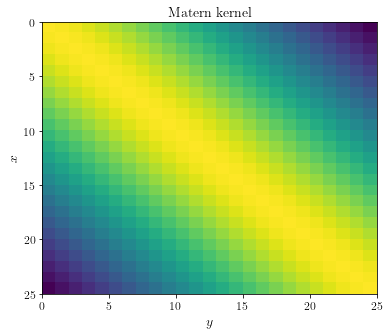

In [6]:
n = 25
pts = np.linspace(0, 1, num=n)
fig, ax = plt.subplots(figsize=(6, 5))
ax.pcolor(get_covariance_matrix(pts).T)
ax.invert_yaxis()
ax.set_ylabel(r"$x$")
ax.set_xlabel(r"$y$")
ax.set_title(f"Matern kernel")
plt.show()

A lognormal Gaussian random field $a(x, \omega)$ can be expressed as $a(x, \omega) = \exp(b(x, \omega))$, where $b(x, \omega)$ is a Gaussian random field. Samples of the Gaussian random field $b(x, \omega)$ can be computed from a factorization of the covariance matrix. Specifically, suppose we have a spectral (eigenvalue) expansion of the covariance matrix $C$ as

$$C = V W V^T,$$

then samples of the Gaussian random field can be computed as

$$\boldsymbol{b} = S \boldsymbol{x},$$

where $S = V W^{1/2}$ and $\boldsymbol{x}$ is a vector of standard normal independent and identically distributed random variables. This is easy to see, since

$$\mathbb{E}[\boldsymbol{b}] = \mathbb{E}[S \boldsymbol{x}] = S\mathbb{E}[\boldsymbol{x}] = \boldsymbol{0}$$
$$\mathbb{E}[\boldsymbol{b} \boldsymbol{b}^T] =  \mathbb{E}[S \boldsymbol{x} \boldsymbol{x}^T S^T] = S \mathbb{E}[\boldsymbol{x} \boldsymbol{x}^T] S^T = SS^T = VWV^T = C.$$


First, let's compute an eigenvalue decomposition of the covariance matrix.

In [7]:
def get_eigenpairs(n, smoothness=1, lengthscale=1):
    h = 1/(n-1)
    pts = np.linspace(h/2, 1 - h/2, num=n - 1)
    cov = get_covariance_matrix(pts, smoothness, lengthscale)
    w, v = np.linalg.eig(cov)
    # ensure all eigenvectors are correctly oriented
    for col in range(v.shape[1]):
        if v[0, col] < 0:
            v[:, col] *= -1
    return pts, w, v

Next, we plot the eigenfunctions for different values of $n$, the number of gridpoints.

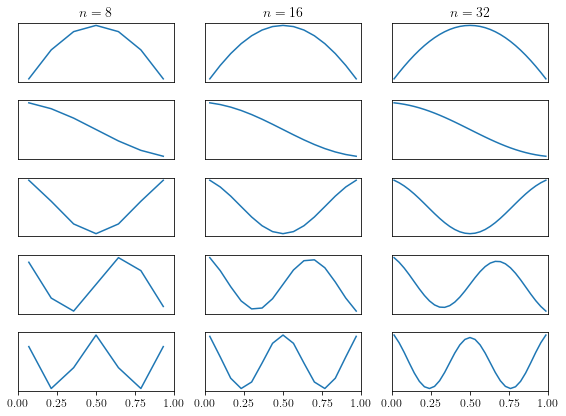

In [8]:
n = [8, 16, 32] # list of number of gridpoints to plot
m = 5 # number of eigenfunctions to plot
fig, axes = plt.subplots(m, len(n), figsize=(8, 6))
for j, k in enumerate(n):
    x, w, v = get_eigenpairs(k)
    for i in range(m):
        axes[i, j].plot(x, v[:, i])
        axes[i, j].set_xlim(0, 1)
        axes[i, j].get_yaxis().set_ticks([])
        if i < m - 1:
            axes[i, j].get_xaxis().set_ticks([])
        if i == 0:
            axes[i, j].set_title(r"$n = " + repr(k) + r"$")
plt.tight_layout()

With this eigenvalue decompoistion, we can compute samples of the Gaussian random field $b(x, \omega)$, and, hence, also of the lognormal Gaussian random field $a(x, \omega) = \exp(b(x, \omega))$, since $\boldsymbol{b} = V W^{1/2} \boldsymbol{x}$.

In [9]:
def evaluate(w, v, y=None):
    if y is None:
        y = np.random.randn(len(w) - 1)
    m = len(y)
    return v[:, :m] @ np.diag(np.sqrt(w[:m])) @ y

Let's plot a couple of realizations of the Gaussian random field $b(x, \omega)$.

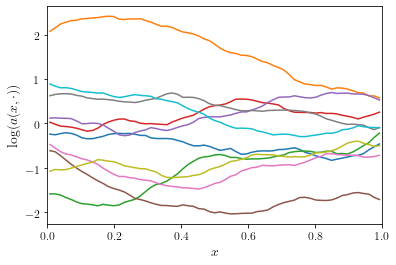

In [10]:
n = 64
x, w, v = get_eigenpairs(n)
fig, ax = plt.subplots(figsize=(6, 4))
for _ in range(10):
    ax.plot(x, evaluate(w, v))
ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\log(a(x, \cdot))$")
plt.show()

Now that we are able to compute realizations of the Gaussian random field, a next step is to compute a numerical solution of the PDE

$$-\frac{d}{dx}\bigg(a(x, \omega) \frac{d}{dx} u(x, \omega) \bigg) = f(x), \quad 0 \leq x \leq 1.$$

Using a straightforward finite-difference approximation, it is easy to show that the numerical solution $\boldsymbol{u}$ is the solution of a tridiagonal system. The solutions of such a tridiagonal system can be easily obtained in $O(n)$ (linear) time using the tridiagonal matrix algorithm (also known as the Thomas algorithm). More details can be found [here](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm).

In [11]:
def thomas(a, b, c, d):
    n = len(b)
    x = np.zeros(n)
    for i in range(1, n):
        w = a[i-1]/b[i-1]
        b[i] -= w*c[i-1]
        d[i] -= w*d[i-1]
    x[n-1] = d[n-1]/b[n-1]
    for i in reversed(range(n-1)):
        x[i] = (d[i] - c[i]*x[i+1])/b[i]
    return x

For the remainder of this notebook, we will assume that the source term $f(x)=1$ and Dirichlet boundary conditions $u(0) = u(1) = 0$.

In [12]:
def pde_solve(a):
    n = len(a)
    b = np.full((n-1, 1), 1/n**2)
    x = thomas(-a[1:n-1], a[:n-1] + a[1:], -a[1:n-1], b)
    return np.insert(x, [0, n-1], [0, 0])

Let's compute and plot a couple of solutions $u(x, \omega)$.

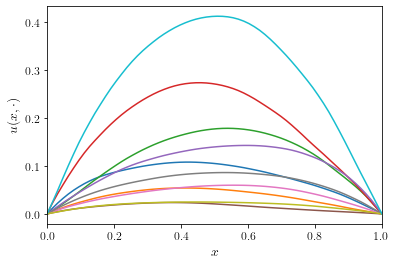

In [13]:
n = 64
_, w, v = get_eigenpairs(n)
x = np.linspace(0, 1, num=n)
fig, ax = plt.subplots(figsize=(6, 4))
for _ in range(10):
    a = np.exp(evaluate(w, v))
    u = pde_solve(a)
    ax.plot(x, u)
ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u(x, \cdot)$")
plt.show()

In the multilevel Monte Carlo method, we will rely on the ability to generate "correlated" solutions of the PDE with varying mesh sizes. Such a correlated solutions can be used as efficient control variates to reduce the variance (or statistical error) in the approximation of the expected value $\mathbb{E}[Q]$. Since we are using a factorization of the covariance matrix to generate realizations of the Gaussian random field, it is quite easy to obtain correlated samples: when sampling from the "coarse" solution level, use the same set of random numbers used to sample from the "fine" solution level, but truncated to the appropriate size. Since the eigenvalue decomposition will reveal the most important modes in the covariance matrix, that same eigenvalue decomposition on a "coarse" approximation level will contain the same eigenfunctions, represented on the coarse grid. Let's illustrate this property on an example using `n = 16` grid points for the fine solution level and `n = 8` grid points for the coarse solution level.

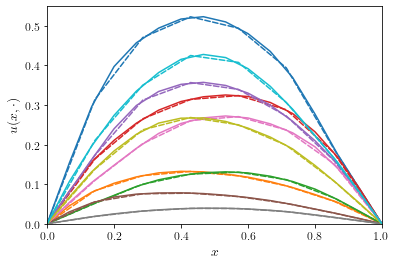

In [14]:
nf = 16
nc = nf//2
_, wf, vf = get_eigenpairs(nf)
_, wc, vc = get_eigenpairs(nc)
xf = np.linspace(0, 1, num=nf)
xc = np.linspace(0, 1, num=nc)
fig, ax = plt.subplots(figsize=(6, 4))
for _ in range(10):
    yf = np.random.randn(nf - 1)
    af = np.exp(evaluate(wf, vf, y=yf))
    uf = pde_solve(af)
    ax.plot(xf, uf)
    yc = yf[:nc - 1]
    ac = np.exp(evaluate(wc, vc, y=yc))
    uc = pde_solve(ac)
    ax.plot(xc, uc, color=ax.lines[-1].get_color(), linestyle="dashed", dash_capstyle="round")
ax.set_xlim(0, 1)
ax.set_ylim(bottom=0)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u(x, \cdot)$")
plt.show()

The better the coarse solution matches the fine grid solution, the more efficient the multilevel methods in Section 3 will perform.

## 2. Single-level methods

Let's begin by using the single-level Monte Carlo and quasi-Monte Carlo methods to compute the expected value $\mathbb{E}[Q]$. As quantity of interest $Q$ we take the solution of the PDE at $x=1/2$, i.e., $Q = u(1/2, \cdot)$.

To integrate the elliptic PDE problem into `QMCPy`, we construct a simple class as follows:

In [15]:
class EllipticPDE(Integrand):
    
    def __init__(self, sampler, smoothness=1, lengthscale=1):
        self.parameters = ["smoothness", "lengthscale", "n"]
        self.smoothness = smoothness
        self.lengthscale = lengthscale
        self.n = len(sampler.gen_samples(n=1)[0]) + 1
        self.compute_eigenpairs()
        self.true_measure = qp.Gaussian(sampler)
        super(EllipticPDE, self).__init__()
        
    def compute_eigenpairs(self):
        _, w, v = get_eigenpairs(self.n)
        self.eigenpairs = w, v
        
    def g(self, x):
        n, d = x.shape
        return np.array([self._g(x[j, :].T) for j in range(n)])
    
    def _g(self, x):
        w, v = self.eigenpairs
        a = np.exp(evaluate(w, v, y=x))
        u = pde_solve(a)
        return u[len(u)//2]

In [16]:
# Custom print function
def print_data(data):
    for key, val in vars(data).items():
        kv = getattr(data, key)
        if hasattr(kv, "parameters"):
            print(f"{key}: {type(val).__name__}")
            for param in kv.parameters:
                print(f"\t{param}: {getattr(kv, param)}")
    for param in data.parameters:
        print(f"{param}: {getattr(data, param)}")

In [17]:
# Main function to test different methods
def test(problem, sampler, stopping_criterium, abs_tol=5e-3, verbose=True, **kwargs):
    integrand = problem(sampler)
    solution, data = stopping_criterium(integrand, abs_tol=abs_tol, **kwargs).integrate()
    if verbose:
        print_data(data)
        print("\nComputed solution {:5.3f} in {:4.2f} s".format(solution, data.time_integrate))

Next, let's apply simple Monte Carlo to approximate the expected value $\mathbb{E}[Q]$. The Monte Carlo estimator for $\mathbb{E}[Q]$ is simply the sample average over a finite set of samples, i.e.,

$$\mathcal{Q}_N^\text{MC} := \frac{1}{N} \sum_{n=0}^{N-1} Q^{(n)},$$

where $Q^{(n)} := u(1/2, \boldsymbol{x}^{(n)})$ and we explicitly denote the dependency of $Q$ on the standard normal random numbers $\boldsymbol{x}$ used to sample from the Gaussian random field. We will continue to increase the number of samples $N$ until a certain error criterium is satisfied.

In [18]:
# MC
test(EllipticPDE, qp.IIDStdUniform(32), qp.CubMCCLT)

stopping_crit: CubMCCLT
	inflate: 1.2
	alpha: 0.01
	abs_tol: 0.005
	rel_tol: 0.0
	n_init: 1024.0
	n_max: 10000000000.0
integrand: EllipticPDE
	smoothness: 1
	lengthscale: 1
	n: 33
true_measure: Gaussian
	mean: 0.0
	covariance: 1.0
	decomp_type: pca
discrete_distrib: IIDStdUniform
	d: 32
	seed: 329626
	mimics: StdUniform
levels: 1
solution: 0.18639926306007548
n: [15201.]
n_total: 16225.0
error_bound: 0.005725143270603197
confid_int: [0.181 0.192]

Computed solution 0.186 in 5.39 s


The solution should be $\approx 0.189$.

Similarly, the quasi-Monte Carlo estimator for $\mathbb{E}[Q]$ is defined as

$$\mathcal{Q}_N^\text{QMC} := \frac{1}{N} \sum_{n=0}^{N-1} Q^{(n)},$$

where $Q^{(n)} := u(1/2, \boldsymbol{t}^{(n)})$ with $\boldsymbol{t}^{(n)}$ the $n$th low-discrepancy point transformed to the distribution of interest. For our elliptic PDE, this means that the quasi-Monte Carlo points, generated inside the unit cube $[0, 1)^d$, are mapped to $\mathbb{R}^d$.

Because the quasi-Monte Carlo estimator doesn't come with a reliable error estimator, we run $K$ different quasi-Monte Carlo estimators in parallel. The sample variance over these $K$ different estimators can then be used as an error estimator.

In [19]:
# QMC
test(EllipticPDE, qp.Sobol(32), qp.CubQMCCLT, n_init=32)

stopping_crit: CubQMCCLT
	inflate: 1.2
	alpha: 0.01
	abs_tol: 0.005
	rel_tol: 0.0
	n_init: 32.0
	n_max: 1073741824.0
integrand: EllipticPDE
	smoothness: 1
	lengthscale: 1
	n: 33
true_measure: Gaussian
	mean: 0.0
	covariance: 1.0
	decomp_type: pca
discrete_distrib: Sobol
	d: 32
	randomize: 1
	graycode: False
	seed: 4642
	mimics: StdUniform
	dim0: 0
replications: 16.0
solution: 0.18893623287717926
sighat: 0.003602155491905335
n_total: 2048.0
error_bound: 0.00278356130159681
confid_int: [0.186 0.192]

Computed solution 0.189 in 2.08 s


## 3. Multilevel methods

Implicit to the Monte Carlo and quasi-Monte Carlo methods above is a discretization parameter used in the numerical solution of the PDE. Let's denote this parameter by $\ell$, $0 \leq \ell \leq L$. Multilevel methods are based on a telescopic sum expansion for the expected value $\mathbb{E}[Q_L]$, as follows:

$$\mathbb{E}[Q_L] = \mathbb{E}[Q_0] + \mathbb{E}[Q_1 - Q_0] + ... + \mathbb{E}[Q_L - Q_{L-1}].$$

Using a Monte Carlo method for each of the terms on the right hand side yields a multilevel Monte Carlo method. Similarly, using a quasi-Monte Carlo method for each term on the right hand side yields a multilevel quasi-Monte Carlo method.

### 3.1 Multilevel (quasi-)Monte Carlo

Our class `EllipticPDE` needs some changes to be integrated with the multilevel methods in `QMCPy`.

In [20]:
class MLEllipticPDE(Integrand):
    
    def __init__(self, sampler, smoothness=1, lengthscale=1):
        self.parameters = ["smoothness", "lengthscale", "n", "nb_of_levels"]
        self.smoothness = smoothness
        self.lengthscale = lengthscale
        dim = sampler.d + 1
        self.nb_of_levels = int(np.log2(dim + 1))
        self.n = [2**(l+1) + 1 for l in range(self.nb_of_levels)]
        self.compute_eigenpairs()
        self.true_measure = qp.Gaussian(sampler)
        self.leveltype = "adaptive-multi"
        self.sums = np.zeros(6)
        self.cost = 0
        super(MLEllipticPDE, self).__init__()
        
    def compute_eigenpairs(self):
        self.eigenpairs = {}
        for l in range(self.nb_of_levels):
            _, w, v = get_eigenpairs(self.n[l])
            self.eigenpairs[l] = w, v
        
    def g(self, x, l): # This function is called by keyword reference for the level parameter "l"!
        n, d = x.shape
        
        Qf = np.array([self._g(x[j, :].T, l) for j in range(n)])
        dQ = Qf
        if l > 0: # Compute multilevel difference
            dQ -= np.array([self._g(x[j, :].T, l - 1) for j in range(n)])
            
        self.update_sums(dQ, Qf)
        self.cost = n*nf
            
        return dQ
    
    def _g(self, x, l):
        w, v = self.eigenpairs[l]
        n = self.n[l]
        a = np.exp(evaluate(w, v, y=x[:n-1]))
        u = pde_solve(a)
        return u[len(u)//2]
    
    def update_sums(self, dQ, Qf):
        self.sums[0] = dQ.sum()
        self.sums[1] = (dQ**2).sum()
        self.sums[2] = (dQ**3).sum()
        self.sums[3] = (dQ**4).sum()
        self.sums[4] = Qf.sum()
        self.sums[5] = (Qf**2).sum()
  
    def _dim_at_level(self, l):
        return self.n[l]

Let's apply multilevel Monte Carlo to the elliptic PDE problem.

In [21]:
test(MLEllipticPDE, qp.IIDStdUniform(32), qp.CubMCML)

stopping_crit: CubMCML
	rmse_tol: 0.0019411224156473219
	n_init: 256.0
	levels_min: 2.0
	levels_max: 10.0
	theta: 0.5
integrand: MLEllipticPDE
	smoothness: 1
	lengthscale: 1
	n: [3, 5, 9, 17, 33]
	nb_of_levels: 5
true_measure: Gaussian
	mean: 0.0
	covariance: 1.0
	decomp_type: pca
discrete_distrib: IIDStdUniform
	d: 9.0
	seed: 474976
	mimics: StdUniform
levels: 3
dimensions: [3. 5. 9.]
n_level: [33183.  3054.  1527.]
mean_level: [1.914e-01 2.380e-04 2.975e-05]
var_level: [5.499e-02 4.576e-04 5.720e-05]
cost_per_sample: [16. 16. 16.]
n_total: 41296.0
alpha: 3.000000000000009
beta: 3.0000000000000133
gamma: 0.5

Computed solution 0.191 in 2.68 s


Now it's easy to switch to multilevel quasi-Monte Carlo. Just change the discrete distribution from `IIDStdUniform` to `Sobol`.

In [22]:
test(MLEllipticPDE, qp.Sobol(32), qp.CubQMCML, n_init=32)

stopping_crit: CubQMCML
	rmse_tol: 0.0019411224156473219
	n_init: 32.0
	n_max: 10000000000.0
	replications: 32.0
integrand: MLEllipticPDE
	smoothness: 1
	lengthscale: 1
	n: [3, 5, 9, 17, 33]
	nb_of_levels: 5
true_measure: Gaussian
	mean: 0.0
	covariance: 1.0
	decomp_type: pca
discrete_distrib: Sobol
	d: 17
	randomize: 1
	graycode: False
	seed: 640254
	mimics: StdUniform
	dim0: 0
levels: 4
dimensions: [ 3.  5.  9. 17.]
n_level: [1024.   64.   32.   32.]
mean_level: [ 1.896e-01 -3.142e-05 -1.338e-04 -4.093e-05]
var_level: [4.647e-07 1.216e-06 1.319e-07 8.145e-09]
bias_estimate: 5.520013794755746e-06
n_total: 36864.0

Computed solution 0.189 in 10.13 s


### 3.2 Continuation multilevel (quasi-)Monte Carlo

In the continuation multilevel (quasi-)Monte Carlo method, we run the standard multilevel (quasi-)Monte Carlo method for a sequence of larger tolerances to obtain better estimates of the algorithmic parameters. The continuation multilevel heurisitc will generally compute the same solution just a bit faster.

In [23]:
test(MLEllipticPDE, qp.IIDStdUniform(32), qp.CubMCMLCont)

stopping_crit: CubMCMLCont
	rmse_tol: 0.0019411224156473219
	n_init: 256.0
	levels_min: 2.0
	levels_max: 10.0
	n_tols: 10
	tol_mult: 1.6681005372000588
	theta_init: 0.5
	theta: 0.01
integrand: MLEllipticPDE
	smoothness: 1
	lengthscale: 1
	n: [3, 5, 9, 17, 33]
	nb_of_levels: 5
true_measure: Gaussian
	mean: 0.0
	covariance: 1.0
	decomp_type: pca
discrete_distrib: IIDStdUniform
	d: 9.0
	seed: 322456
	mimics: StdUniform
levels: 3
dimensions: [ 3.  5.  9. 17.]
n_level: [17162.  1356.   264.   256.]
mean_level: [0.191 0.001 0.   ]
var_level: [5.816e-02 2.954e-04 1.349e-05]
cost_per_sample: [16. 16. 16.]
n_total: 27881.0
alpha: 2.166638622480736
beta: 4.452015345286275
gamma: 0.5

Computed solution 0.192 in 1.39 s


In [24]:
test(MLEllipticPDE, qp.Sobol(32), qp.CubQMCMLCont, n_init=32)

stopping_crit: CubQMCMLCont
	rmse_tol: 0.0019411224156473219
	n_init: 32.0
	n_max: 10000000000.0
	replications: 32.0
	levels_min: 2
	levels_max: 10
	n_tols: 10
	tol_mult: 1.6681005372000588
	theta_init: 0.5
	theta: 0.01
integrand: MLEllipticPDE
	smoothness: 1
	lengthscale: 1
	n: [3, 5, 9, 17, 33]
	nb_of_levels: 5
true_measure: Gaussian
	mean: 0.0
	covariance: 1.0
	decomp_type: pca
discrete_distrib: Sobol
	d: 3
	randomize: 1
	graycode: False
	seed: 2826
	mimics: StdUniform
	dim0: 0
levels: 3
dimensions: [3. 5. 9.]
n_level: [2048.   32.   32.]
mean_level: [1.899e-01 3.689e-04 3.523e-05]
var_level: [5.664e-07 2.114e-06 1.418e-07]
bias_estimate: 3.5527438541060685e-07
n_total: 67584.0

Computed solution 0.190 in 9.89 s


## 4. Convergence tests

Finally, we will run some convergence tests to see how these method behave as a function of the error tolerance.

In [25]:
# Main function to test convergence for given problem
def test_convergence(problem, sampler, stopping_criterium, abs_tol=1e-3, verbose=True, smoothness=1, lengthscale=1, **kwargs):
    integrand = problem(sampler, smoothness=smoothness, lengthscale=lengthscale)
    stopping_crit = stopping_criterium(integrand, abs_tol=abs_tol, **kwargs)
    
    # get accumulate_data
    try:
        stopping_crit.data = MLQMCData(stopping_crit, stopping_crit.integrand, stopping_crit.true_measure, stopping_crit.discrete_distrib, stopping_crit.levels_min, stopping_crit.levels_max, stopping_crit.n_init, stopping_crit.replications)
    except:
        stopping_crit.data = MLMCData(stopping_crit, stopping_crit.integrand, stopping_crit.true_measure, stopping_crit.discrete_distrib, stopping_crit.levels_min, stopping_crit.n_init, -1., -1., -1.)
    
    # manually call "integrate()"
    tol = []
    n_samp = []
    for t in range(stopping_crit.n_tols):
        stopping_crit.rmse_tol = stopping_crit.tol_mult**(stopping_crit.n_tols-t-1)*stopping_crit.target_tol # update tol
        stopping_crit._integrate() # call _integrate()
        tol.append(copy.copy(stopping_crit.rmse_tol))
        n_samp.append(copy.copy(stopping_crit.data.n_level))

        if verbose:
            print("tol = {:5.3e}, number of samples = {}".format(tol[-1], n_samp[-1]))
            
    return tol, n_samp

In [26]:
# Execute the convergence test
def execute_convergence_test(smoothness=1, lengthscale=1):
    
    # Convergence test for MLMC
    tol_mlmc, n_samp_mlmc = test_convergence(MLEllipticPDE, qp.IIDStdUniform(32), qp.CubMCMLCont, verbose=False)
    
    # Convergence test for MLQMC
    tol_mlqmc, n_samp_mlqmc = test_convergence(MLEllipticPDE, qp.Sobol(32), qp.CubQMCMLCont, verbose=False, n_init=32)
    
    # Compute cost per level
    max_levels = max(max([len(n_samp) for n_samp in n_samp_mlmc]), max([len(n_samp) for n_samp in n_samp_mlqmc]))
    cost_per_level = np.array([2**level + int(2**(level-1)) for level in range(max_levels)])
    cost_per_level = cost_per_level/cost_per_level[-1]
    
    # Compute total cost for each tolerance and store the result
    cost = {}
    cost["mc"] = (tol_mlmc, [n_samp_mlmc[tol][0] for tol in range(len(tol_mlmc))]) # where we assume V[Q_0] = V[Q_L]
    cost["qmc"] = (tol_mlqmc, [n_samp_mlqmc[tol][0] for tol in range(len(tol_mlqmc))]) # where we assume V[Q_0] = V[Q_L]
    cost["mlmc"] = (tol_mlmc, [sum([n_samp*cost_per_level[j] for j, n_samp in enumerate(n_samp_mlmc[tol])]) for tol in range(len(tol_mlmc))])
    cost["mlqmc"] = (tol_mlqmc, [sum([n_samp*cost_per_level[j] for j, n_samp in enumerate(n_samp_mlqmc[tol])]) for tol in range(len(tol_mlqmc))])
    
    return cost

In [27]:
# Plot the result
def plot_convergence(cost):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(cost["mc"][0], cost["mc"][1], marker="o", label="MC")
    ax.plot(cost["qmc"][0], cost["qmc"][1], marker="o", label="QMC")
    ax.plot(cost["mlmc"][0], cost["mlmc"][1], marker="o", label="MLMC")
    ax.plot(cost["mlqmc"][0], cost["mlqmc"][1], marker="o", label="MLQMC")
    ax.legend(frameon=False)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"error tolerance $\varepsilon$")
    ax.set_ylabel(r"equivalent \# model evaluations at finest level")
    plt.show()

This command takes a while to execute (about 1 minute on my laptop):

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


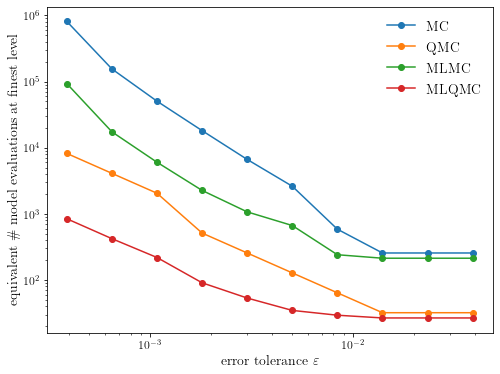

In [28]:
plot_convergence(execute_convergence_test())

The benefit of the low-discrepancy point set depends on the smoothness of the random field: the smoother the random field, the better. Here's an example for a Gaussian random field with a smaller smoothness $\nu=1/2$ and smaller lengthscale $\lambda=1/3$.

In [29]:
smoothness = 1/2
lengthscale = 1/3

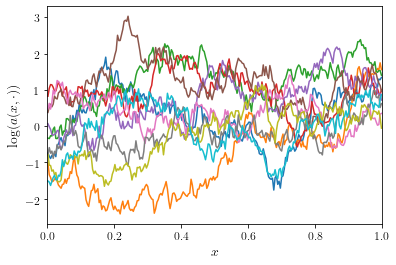

In [30]:
n = 256
x, w, v = get_eigenpairs(n, smoothness=smoothness, lengthscale=lengthscale)
fig, ax = plt.subplots(figsize=(6, 4))
for _ in range(10):
    ax.plot(x, evaluate(w, v))
ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\log(a(x, \cdot))$")
plt.show()

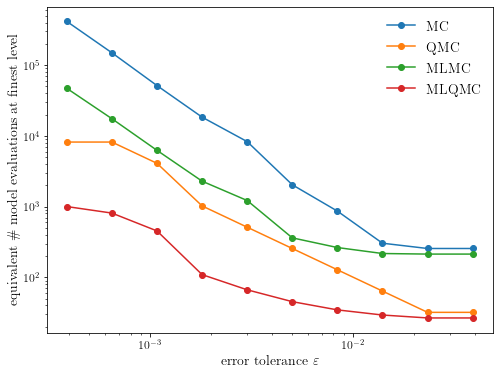

In [31]:
plot_convergence(execute_convergence_test(lengthscale=lengthscale, smoothness=smoothness))

While the multilevel quasi-Monte Carlo method is still the fastest method, the asymptotic cost complexity of the QMC-based methods reduces to approximately the same rate as the MC-based methods.

The benefits of the multilevel methods over single-level methods will be even larger for two- or three-dimensional PDE problems, since it will be even more computationally efficient to take samples on a coarse grid.